<h1><center>London Rental Prices</center></h1>
<h4><center>Using Algorithms to Explore Drivers of and Predict Rental Prices</center></h4>

## Table of Contents

* [Chapter 1](#chapter1): LSOA Data Preparation
    * [Section 1.1](#section_1_1): Preparing LSOA to Postcode Map
    * [Section 1.2](#section_1_2): Preparing LSOA Characteristics Dataset
* [Chapter 2](#chapter2): Zoopla Data Preparation
* [Chapter 3](#chapter3): Merging Datasets
* [Chapter 4](#chapter4): Data Cleaning and Exploration
    * [Section 4.1](#section_4_1): Data Cleaning
    * [Section 4.2](#section_4_2): Data Exploration
* [Chapter 5](#chapter5): Statistical Model
* [Chapter 6](#chapter6): References

## Chapter 1: <a class="anchor" id="chapter1"></a> LSOA Data Preparation

### Section 1.1: <a class="anchor" id="section_1_1"></a> Preparing LSOA to Postcode Map

In [1]:
#Importing libraries
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import plotly.express as px
from IPython.display import Image
import matplotlib.ticker as mtick
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import linear_model

In [2]:
#Importing map from LSOA areas to London postcodes
dfmap = pd.read_csv("Data/PCD_LSOA_Map_VUncleaned.csv", dtype = {"pcd": str, "lsoa11": str, "lat": float, "long": float})                                                              

/Users/claragoebel/opt/anaconda3/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (45) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
#Selecting relevant columns from map 
dfmap = dfmap[["pcd", "lsoa11", "lat", "long"]]

In [4]:
#Creating 4-digit postcode
dfmap["pcd_adjusted"] = dfmap["pcd"].str[0:4].str.strip()

In [5]:
dfmap.head()

,pcd,lsoa11,lat,long,pcd_adjusted
0,BR1 1AA,E01000675,51.401546,0.015415,BR1
1,BR1 1AB,E01000676,51.406333,0.015208,BR1
2,BR1 1AD,E01000675,51.400057,0.016715,BR1
3,BR1 1AE,E01000677,51.404543,0.014195,BR1
4,BR1 1AF,E01000675,51.401392,0.014948,BR1


In [6]:
#Saving to CSV
dfmap.to_csv("Data/PCD_LSOA_Map_VCleaned.csv")

### Section 1.2: <a class="anchor" id="section_1_2"></a> Preparing LSOA Characteristics Dataset

In [7]:
#Importing data on LSOA area characteristics
dflsoa1 = pd.read_csv("Data/LSOA_Data_Various_VInitialCleaned1.csv", header = 0)
dflsoa2 = pd.read_csv("Data/LSOA_Data_Various_VInitialCleaned2.csv", header = 0)

In [8]:
#Combining LSOA datasets
dflsoa = pd.merge_ordered(dflsoa1, dflsoa2, how = "outer", on = "lsoa11")
dflsoa.head()

,lsoa11,all_ages,ages_0_15,ages_16_29,ages_30_44,ages_45_65,ages_66_plus,pop_density,couple_children_dependent,couple_children_nondependent,...,level_2,apprenticeship,level_3,level_4,other,good_health,fair_health,bad_health,public_transport_accessibility,mean_income
0,E01000001,1474,141,177,368,454,334,114,7.6,30.6,...,5.6,0.5,7.0,77.6,5.0,88.6,9.4,2.0,8.0,74846
1,E01000002,1455,179,135,344,486,311,64,10.4,30.7,...,5.5,0.4,7.0,79.2,2.4,89.9,7.4,2.7,8.0,73325
2,E01000003,1357,135,196,383,368,275,230,6.2,19.1,...,8.9,1.5,7.5,56.8,5.7,80.7,13.2,6.2,7.3,44130
3,E01000005,1172,184,349,240,250,149,62,13.1,14.3,...,11.2,0.9,9.5,34.5,11.4,79.4,13.3,7.3,8.0,30781
4,E01000006,1714,416,387,474,303,134,117,25.6,21.7,...,12.9,1.5,8.8,32.9,13.8,86.1,9.7,4.2,6.4,46141


In [9]:
#Transforming ages into percentages of total population
for key in dflsoa.columns:
    if "ages_" in key:
        dflsoa[key] = dflsoa[key] / dflsoa["all_ages"]
dflsoa.head()
dflsoa = dflsoa.drop(labels = "all_ages", axis = 1).reset_index(drop=True)

In [10]:
#Transforming household types, ownership types, resident types, and dwelling types into percentages
for key in dflsoa.columns[7:22]:
    dflsoa[key] = dflsoa[key] / 100
dflsoa.iloc[:,7:22].head()

,couple_children_dependent,couple_children_nondependent,lone_parent,single,other_multi,owned_outright,owned_mortgage,rented_social,rented_private,usual_residents,nonusual_residents,house_detached,house_semidetached,house_terraced,flat
0,0.076,0.306,0.026,0.517,0.074,0.405,0.203,0.047,0.301,0.866,0.134,0.000,0.002,0.009,0.989
1,0.104,0.307,0.027,0.504,0.059,0.378,0.257,0.058,0.264,0.850,0.150,0.001,0.001,0.035,0.963
2,0.062,0.191,0.060,0.621,0.066,0.225,0.175,0.361,0.217,0.921,0.079,0.000,0.000,0.003,0.997
3,0.131,0.143,0.094,0.488,0.143,0.051,0.047,0.668,0.216,0.884,0.116,0.002,0.002,0.000,0.996
4,0.256,0.217,0.099,0.179,0.249,0.250,0.385,0.033,0.328,0.973,0.027,0.057,0.154,0.532,0.256


In [11]:
#Transforming economic activity into percentages
total_economic = dflsoa["economic_active"] + dflsoa["economic_inactive"]
for key in dflsoa.columns[23:28]:
    dflsoa[key] = dflsoa[key] / total_economic
dflsoa.iloc[:,23:28].head()

,economic_inactive,employee,self-employed,unemployed,student
0,0.210483,0.552007,0.196560,0.027846,0.013104
1,0.225753,0.545151,0.203177,0.013378,0.012542
2,0.254083,0.500000,0.171506,0.035390,0.039020
3,0.314360,0.522639,0.065977,0.059508,0.037516
4,0.301359,0.451639,0.134293,0.066347,0.046363


In [12]:
#Transforming educational background, and health into percentages
for key in dflsoa.columns[28:38]:
    dflsoa[key] = dflsoa[key] / 100
dflsoa.iloc[:,28:38].head()

,unqualified,level_1,level_2,apprenticeship,level_3,level_4,other,good_health,fair_health,bad_health
0,0.019,0.026,0.056,0.005,0.070,0.776,0.050,0.886,0.094,0.020
1,0.023,0.032,0.055,0.004,0.070,0.792,0.024,0.899,0.074,0.027
2,0.130,0.065,0.089,0.015,0.075,0.568,0.057,0.807,0.132,0.062
3,0.244,0.082,0.112,0.009,0.095,0.345,0.114,0.794,0.133,0.073
4,0.182,0.118,0.129,0.015,0.088,0.329,0.138,0.861,0.097,0.042


In [13]:
#Saving to csv
dflsoa.to_csv("Data/LSOA_Data_Various_VCleaned.csv")

In [14]:
#Merging LSOA to postcode map and LSOA dataset
dflsoapcd = pd.merge_ordered(dfmap, dflsoa, how = "outer", on = "lsoa11")

In [15]:
#Calculating mean characteristics per postcode
dflsoapcdagg = dflsoapcd.groupby("pcd_adjusted").mean()
dflsoapcdagg = dflsoapcdagg.reset_index()

In [16]:
#Final output
dflsoapcdagg.head()

,pcd_adjusted,lat,long,ages_0_15,ages_16_29,ages_30_44,ages_45_65,ages_66_plus,pop_density,couple_children_dependent,...,level_2,apprenticeship,level_3,level_4,other,good_health,fair_health,bad_health,public_transport_accessibility,mean_income
0,BR1,51.410732,0.019415,0.200197,0.184432,0.266825,0.206121,0.142425,53.109932,0.177784,...,0.141285,0.016237,0.116889,0.375419,0.064169,0.834714,0.118985,0.046662,4.166876,47394.319672
1,BR2,51.390367,0.021651,0.195533,0.162796,0.230801,0.242602,0.168268,40.645046,0.204164,...,0.158576,0.024602,0.118528,0.362727,0.050766,0.852551,0.110375,0.037241,3.382324,52311.475410
2,BR3,51.403432,-0.031687,0.177087,0.154993,0.249727,0.253015,0.165178,46.816619,0.186629,...,0.147975,0.021729,0.115286,0.380142,0.050838,0.846788,0.112853,0.040332,3.314852,52835.364852
3,BR4,51.375663,-0.009914,0.190778,0.157745,0.157827,0.290359,0.203291,38.000000,0.265253,...,0.185656,0.028580,0.132585,0.310932,0.042361,0.855533,0.112085,0.032337,2.313542,57316.548611
4,BR5,51.389215,0.102548,0.216796,0.168630,0.197267,0.248180,0.169127,42.094181,0.200479,...,0.161550,0.030633,0.109114,0.246882,0.049559,0.821891,0.127713,0.050408,2.955436,43241.883614


In [17]:
#Saving to CSV
dflsoapcd.to_csv("Data/LSOA_Data_Various_Incl_PCD_VCleaned.csv")
dflsoapcdagg.to_csv("Data/LSOA_Data_Various_Incl_PCD_Agg_VCleaned.csv")

## Chapter 2: <a class="anchor" id="chapter2"></a> Zoopla Data Preparation

In [18]:
#Importing webscraped Zoopla data
dfzoopla = pd.read_excel("Data/Zoopla_listings.xlsx", index_col = 0)

In [19]:
#Cleaning Nr_Beds
for index, row in dfzoopla.iterrows():
    if row["List_Name"][0:2].strip().isnumeric():
        dfzoopla.loc[index, "Nr_Beds"] = int(row["List_Name"][0:2].strip())
        dfzoopla.loc[index, "Check_nr_beds"] = int(row["List_Name"][0:2].strip())
    elif row["List_Name"].split()[0] == "Studio":
        dfzoopla.loc[index, "Nr_Beds"] = 1
        dfzoopla.loc[index, "Nr_Baths"] = 1
        dfzoopla.loc[index, "Check_nr_beds"] = 1
    else:
        continue

In [20]:
#Checking above iteration
dfzoopla[dfzoopla["Nr_Beds"] != dfzoopla["Check_nr_beds"]].head()

,Price,Nr_Beds,Nr_Baths,Postcode,Address,List_Name,Station_1,Station_2,Check_nr_beds
117,3002,2,1,E2,"Voss Street, London E2",Serviced flat to rent,Bethnal Green,Bethnal Green,NaN
676,8082,2,2,E1,"Brune Street, London E1",Serviced flat to rent,Aldgate East,Aldgate,NaN
748,1170,1,1,NW1,"Parkway, London NW1",Property to rent,Camden Town,Mornington Crescent,NaN
913,3924,2,1,NW8,"Frampton Street, London NW8",Serviced flat to rent,Edgware Road Bakerloo,Edgware Road Circle,NaN
1594,8732,2,3,SW7,"Queensberry Mews West, London SW7",Serviced town house to rent,South Kensington,Gloucester Road,NaN


In [21]:
#Cleaning postcode
dfzoopla["Postcode"] = dfzoopla["Postcode"].apply(lambda x: x.replace(',',''))
dfzoopla["Postcode"] = dfzoopla["Postcode"].apply(lambda x: x.replace('.',''))
dfzoopla.iloc[2874,3] = "SW7"
dfzoopla.iloc[644,3] = "SW7"
dfzoopla.iloc[5124,3] = "WC1H"
dfzoopla.iloc[5125,3] = "WC1H"
dfzoopla.iloc[5126,3] = "WC1H"
dfzoopla.iloc[5260,3] = "SW1X"

In [22]:
#Removing obsolete columns
dfzoopla = dfzoopla[["Price", "Nr_Beds", "Nr_Baths", "Postcode", "Station_1", "Station_2"]]

In [23]:
#Final output
dfzoopla.head()

,Price,Nr_Beds,Nr_Baths,Postcode,Station_1,Station_2
0,3120,2,2,SE1,Lambeth Pier,Millbank Millennium Pier
1,2700,2,2,SE1,London Bridge,Borough
2,4117,3,2,SE1,London Bridge,St Katharine's Pier
3,3033,1,1,SE1,St Katharine's Pier,Tower Millennium Pier
4,3792,1,1,NW1,Baker Street,Marylebone


In [24]:
#Saving to CSV
dfzoopla.to_csv("Data/Zoopla_VCleaned.csv")

## Chapter 3: <a class="anchor" id="chapter3"></a> Merging Datasets

In [25]:
#Importing data
dflsoa = pd.read_csv("Data/LSOA_Data_Various_Incl_PCD_Agg_VCleaned.csv", index_col = 0)
dfzoopla = pd.read_csv("Data/Zoopla_VCleaned.csv", index_col = 0)

In [26]:
#Renaming columns for Zoopla dataset
dflsoa = dflsoa.rename(columns = {"pcd_adjusted": "pcd"})
dfzoopla = dfzoopla.rename(columns = {"Price": "price", 
                         "Nr_Beds": "nr_beds", 
                         "Nr_Baths": "nr_baths", 
                         "Postcode": "pcd", 
                         "Station_1": "station_1",
                         "Station_2": "station_2"})

In [27]:
#Merging datasets
df = pd.merge(dfzoopla, dflsoa, how = "left", on = "pcd")
df.head()

,price,nr_beds,nr_baths,pcd,station_1,station_2,lat,long,ages_0_15,ages_16_29,...,level_2,apprenticeship,level_3,level_4,other,good_health,fair_health,bad_health,public_transport_accessibility,mean_income
0,3120,2,2,SE1,Lambeth Pier,Millbank Millennium Pier,51.498191,-0.090293,0.128865,0.321420,...,0.080018,0.008882,0.127582,0.483684,0.082278,0.853440,0.102529,0.044135,6.544094,47944.873664
1,2700,2,2,SE1,London Bridge,Borough,51.498191,-0.090293,0.128865,0.321420,...,0.080018,0.008882,0.127582,0.483684,0.082278,0.853440,0.102529,0.044135,6.544094,47944.873664
2,4117,3,2,SE1,London Bridge,St Katharine's Pier,51.498191,-0.090293,0.128865,0.321420,...,0.080018,0.008882,0.127582,0.483684,0.082278,0.853440,0.102529,0.044135,6.544094,47944.873664
3,3033,1,1,SE1,St Katharine's Pier,Tower Millennium Pier,51.498191,-0.090293,0.128865,0.321420,...,0.080018,0.008882,0.127582,0.483684,0.082278,0.853440,0.102529,0.044135,6.544094,47944.873664
4,3792,1,1,NW1,Baker Street,Marylebone,51.532260,-0.142795,0.156290,0.332249,...,0.079545,0.007748,0.175979,0.427222,0.103377,0.844381,0.101470,0.054130,7.078981,47298.153470


In [28]:
#Saving to CSV
df.to_csv("Data/Full_Dataset.csv")

## Chapter 4: <a class="anchor" id="chapter4"></a> Data Cleaning and Exploration

### Section 4.1: <a class="anchor" id="section_4_1"></a> Data Cleaning

In [29]:
#Transforming mean_income to £1'000
df["mean_income"] = df["mean_income"]/1000

In [30]:
#Transforming price to log(price)
df["log_price"] = np.log(df["price"])

In [31]:
#Ensuring consistent spelling of St. in nearest station
df["station_1"] = df["station_1"].str.replace("St ", "St. ")
df["station_1"] = df["station_1"].str.replace("(Intl)", "International")

<ipython-input-31-819e3aa23e34>:3: FutureWarning: The default value of regex will change from True to False in a future version.
  df["station_1"] = df["station_1"].str.replace("(Intl)", "International")


In [32]:
#Removing duplicates in nearest station
for index, row in df.iterrows():
    if row["station_1"] == "London Cannon Street":
        df.loc[index,"station_1"] = "Cannon Street"
    elif row["station_1"] == "London Waterloo":
        df.loc[index,"station_1"] = "Waterloo"
    elif row["station_1"] == "London Waterloo East":
        df.loc[index,"station_1"] = "Waterloo East"
    elif row["station_1"] == "London Paddington":
        df.loc[index,"station_1"] = "Paddington"
    elif row["station_1"] == "London Euston":
        df.loc[index,"station_1"] = "Euston"
    elif row["station_1"] == "London Kings Cross":
        df.loc[index,"station_1"] = "King's Cross St. Pancras" 
    elif row["station_1"] == "London Victoria":
        df.loc[index,"station_1"] = "Victoria" 
    elif row["station_1"] == "London Marylebone":
        df.loc[index,"station_1"] = "Marylebone" 
    elif row["station_1"] == "London Charing Cross":
        df.loc[index,"station_1"] = "Charing Cross"
    elif row["station_1"] == "London Liverpool Street":
        df.loc[index,"station_1"] = "Liverpool Street"
    elif row["station_1"] == "London St. Pancras (International)":
        df.loc[index,"station_1"] = "St. Pancras International"
    elif row["station_1"] == "London St. Pancras International":
        df.loc[index,"station_1"] = "St. Pancras International"
    elif row["station_1"] == "London Fenchurch Street":
        df.loc[index,"station_1"] = "Fenchurch Street"

In [33]:
#Adding "Other" column for house ownership
df["other_ownership"] = 1 - df["owned_outright"] - df["owned_mortgage"] - df["rented_social"] - df["rented_private"] 

In [34]:
#Dropping second nearest station
df = df.drop("station_2", axis = 1)

In [35]:
#Saving CSV
df.to_csv("Data/Full_Dataset_VCleaned.csv")

In [36]:
#Checking datatypes: Datatypes are right
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5382 entries, 0 to 5381
Data columns (total 48 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   price                           5382 non-null   int64  
 1   nr_beds                         5382 non-null   int64  
 2   nr_baths                        5382 non-null   int64  
 3   pcd                             5382 non-null   object 
 4   station_1                       5382 non-null   object 
 5   lat                             5382 non-null   float64
 6   long                            5382 non-null   float64
 7   ages_0_15                       5382 non-null   float64
 8   ages_16_29                      5382 non-null   float64
 9   ages_30_44                      5382 non-null   float64
 10  ages_45_65                      5382 non-null   float64
 11  ages_66_plus                    5382 non-null   float64
 12  pop_density                     53

In [37]:
#Checking missing values: No missing values
share_missing_vals_num = (df.isnull().sum() / len(df))*100
share_missing_vals_str = round(share_missing_vals_num,1).astype(str)+"%"
share_missing_vals_df = pd.DataFrame({"share_of_missing_values": share_missing_vals_str, "share_of_missing_values_num": share_missing_vals_num})
share_missing_vals_df = share_missing_vals_df.sort_values(by = "share_of_missing_values_num", ascending = False)
share_missing_vals_df = share_missing_vals_df.drop("share_of_missing_values_num", axis = 1)
share_missing_vals_df

,share_of_missing_values
price,0.0%
nr_beds,0.0%
house_terraced,0.0%
flat,0.0%
economic_active,0.0%
economic_inactive,0.0%
employee,0.0%
self-employed,0.0%
unemployed,0.0%
student,0.0%


Text(0.5, 0, "Mean income in postcode area (in £1'000)")

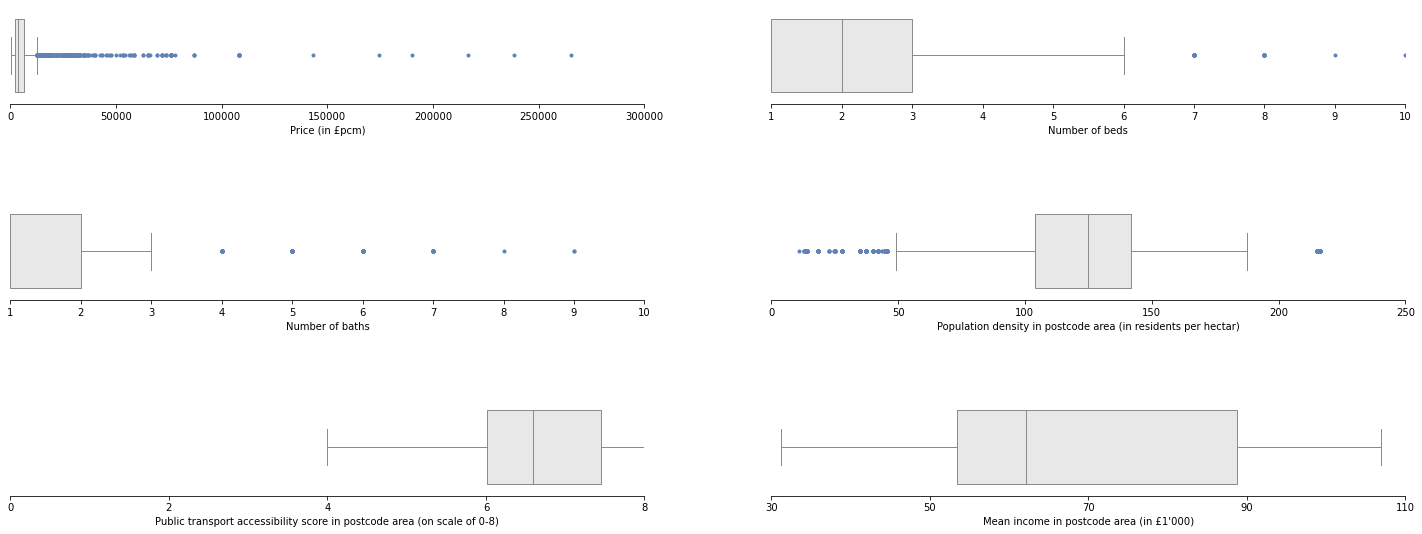

In [38]:
#Checking outliers: Key numeric columns with outliers, particularly for price
fig, ax = plt.subplots(figsize = (25, 9), ncols = 2, nrows = 3)
fig.subplots_adjust(hspace = 1)
sns.despine(left = True, top = True)

#Price
price = sns.boxplot(
    x = "price", 
    data = df, 
    ax = ax[0,0], 
    color = "#E8E8E8", 
    linewidth = 1, 
    width = 0.75,
    flierprops = {"marker": "o", 
                  "markerfacecolor": "#6082B6", 
                  "markersize": 3, 
                  "markeredgecolor": "#6082B6"}
)
price.set_yticks([])
price.set_xlim([0,300000])
price.set_xticks([0,50000,100000,150000,200000,250000,300000])
price.set_xlabel("Price (in £pcm)")

#Beds
beds = sns.boxplot(
    x = "nr_beds", 
    data = df, 
    ax = ax[0,1], 
    color = "#E8E8E8", 
    linewidth = 1, 
    width = 0.75,
    flierprops = {"marker": "o", 
                  "markerfacecolor": "#6082B6", 
                  "markersize": 3, 
                  "markeredgecolor": "#6082B6"}
)
beds.set_yticks([])
beds.set_xlim([1,10])
beds.set_xticks([1,2,3,4,5,6,7,8,9,10])
beds.set_xlabel("Number of beds")

#Baths
baths = sns.boxplot(
    x = "nr_baths", 
    data = df, 
    ax = ax[1,0], 
    color = "#E8E8E8", 
    linewidth = 1, 
    width = 0.75,
    flierprops = {"marker": "o", 
                  "markerfacecolor": "#6082B6", 
                  "markersize": 3, 
                  "markeredgecolor": "#6082B6"}
)
baths.set_yticks([])
baths.set_xlim([1,10])
baths.set_xticks([1,2,3,4,5,6,7,8,9,10])
baths.set_xlabel("Number of baths")

#Population density in postcode area
pop_density = sns.boxplot(
    x = "pop_density", 
    data = df, 
    ax = ax[1,1], 
    color = "#E8E8E8", 
    linewidth = 1, 
    width = 0.75,
    flierprops = {"marker": "o", 
                  "markerfacecolor": "#6082B6", 
                  "markersize": 3, 
                  "markeredgecolor": "#6082B6"}
)
pop_density.set_yticks([])
pop_density.set_xlim([0,250])
pop_density.set_xticks([0,50,100,150,200,250])
pop_density.set_xlabel("Population density in postcode area (in residents per hectar)")

#Public transport accessibility in postcode area
pt_accessibility = sns.boxplot(
    x = "public_transport_accessibility", 
    data = df, 
    ax = ax[2,0], 
    color = "#E8E8E8", 
    linewidth = 1, 
    width = 0.75,
    flierprops = {"marker": "o", 
                  "markerfacecolor": "#6082B6", 
                  "markersize": 3, 
                  "markeredgecolor": "#6082B6"}
)
pt_accessibility.set_yticks([])
pt_accessibility.set_xlim([0,8])
pt_accessibility.set_xticks([0,2,4,6,8])
pt_accessibility.set_xlabel("Public transport accessibility score in postcode area (on scale of 0-8)")

#Mean income in postcode area
mean_income = sns.boxplot(
    x = "mean_income", 
    data = df, 
    ax = ax[2,1], 
    color = "#E8E8E8", 
    linewidth = 1, 
    width = 0.75,
    flierprops = {"marker": "o", 
                  "markerfacecolor": "#6082B6", 
                  "markersize": 3, 
                  "markeredgecolor": "#6082B6"}
)
mean_income.set_yticks([])
mean_income.set_xlim([30,110])
mean_income.set_xticks([30,50,70,90,110])
mean_income.set_xlabel("Mean income in postcode area (in £1'000)")

In [39]:
q1 = df.quantile(0.25)
q3 = df.quantile(0.75)
iqr = q3 - q1
share_outliers_num = (((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))).sum() / len(df))*100
share_outliers_str = round(share_outliers_num,1).astype(str)+"%"
share_outliers_df = pd.DataFrame({"share_of_outliers": share_outliers_str, "share_of_outliers_num": share_outliers_num})
share_outliers_df = share_outliers_df.sort_values(by = "share_of_outliers_num", ascending = False)
share_outliers_df = share_outliers_df.drop("share_of_outliers_num", axis = 1)
share_outliers_df

<ipython-input-39-591c146e7b80>:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  share_outliers_num = (((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))).sum() / len(df))*100
<ipython-input-39-591c146e7b80>:4: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version.  Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  share_outliers_num = (((df < (q1 - 1.5 * iqr)) | (df > (q3 + 1.5 * iqr))).sum() / len(df))*100


,share_of_outliers
ages_0_15,19.2%
pop_density,13.5%
flat,12.1%
house_terraced,11.1%
price,7.8%
level_3,7.7%
nonusual_residents,6.8%
usual_residents,6.8%
nr_baths,6.1%
house_detached,5.9%


Text(0.5, 0, 'Number of listings by nearest station')

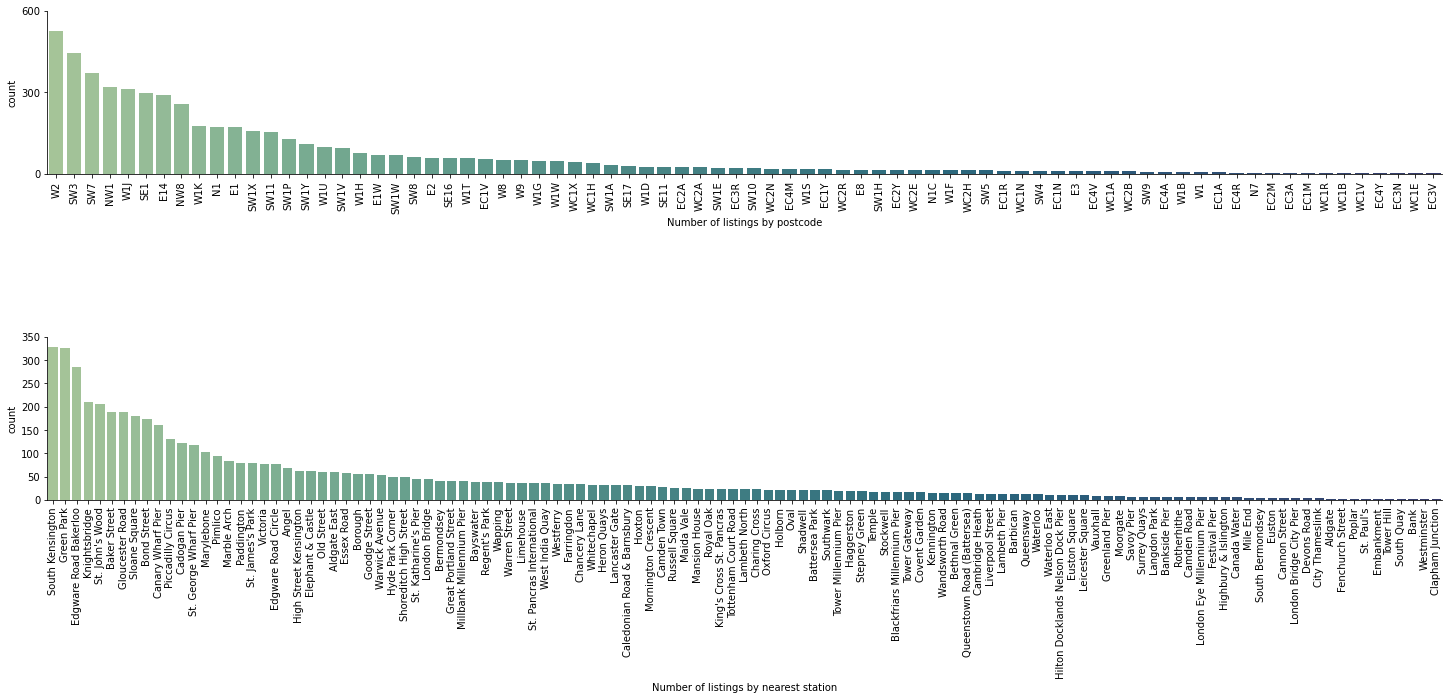

In [40]:
#Impossible values: Key categorical columns without impossible values

fig, ax = plt.subplots(figsize = (25, 9), ncols = 1, nrows = 2)
fig.subplots_adjust(hspace = 1)
sns.despine(top = True)

#Postcode
postcode = sns.countplot(
    x = df["pcd"], 
    data = df,
    ax = ax[0], 
    palette = "crest", 
    order = df["pcd"].value_counts().index)
postcode.set_ylim([0,600])
postcode.set_yticks([0,300,600])
postcode.set_xticklabels(postcode.get_xticklabels(), rotation = 90)
postcode.set_xlabel("Number of listings by postcode")

#Station 1
station_1 = sns.countplot(
    x = df["station_1"], 
    data = df,
    ax = ax[1], 
    palette = "crest", 
    order = df["station_1"].value_counts().index)
station_1.set_ylim([0,350])
station_1.set_yticks([0,50,100,150,200,250,300,350])
station_1.set_xticklabels(station_1.get_xticklabels(), rotation = 90)
station_1.set_xlabel("Number of listings by nearest station")

### Section 4.2: <a class="anchor" id="section_4_2"></a> Data Exploration

In [41]:
#Summary statistics
dfstats = df.describe()
dfstats.loc["skew",] = df.skew(axis = 0, skipna = True)
dfstats.loc["kurtosis",] = df.kurtosis(axis = 0, skipna = True)
dfstats = dfstats.drop(["count", "min", "25%", "50%", "75%", "max"])
dfstats.round(1)

,price,nr_beds,nr_baths,lat,long,ages_0_15,ages_16_29,ages_30_44,ages_45_65,ages_66_plus,...,level_3,level_4,other,good_health,fair_health,bad_health,public_transport_accessibility,mean_income,log_price,other_ownership
mean,6404.5,2.1,1.8,51.5,-0.1,0.1,0.3,0.3,0.2,0.1,...,0.1,0.5,0.1,0.9,0.1,0.0,6.6,70.0,8.4,0.0
std,11111.8,1.2,1.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,...,0.0,0.1,0.0,0.0,0.0,0.0,1.1,19.9,0.8,0.0
skew,10.1,1.3,1.7,-0.2,1.0,-0.2,0.5,0.4,-0.1,0.2,...,2.0,0.2,-0.3,0.3,-0.4,0.0,-0.6,0.4,0.9,1.3
kurtosis,158.4,2.2,4.3,-0.3,0.3,-0.1,0.2,-0.3,-0.6,-0.7,...,4.5,-0.0,-0.7,-0.5,-0.5,-0.4,-0.2,-1.3,1.7,1.8


Text(0.5, 0, 'Number of baths')

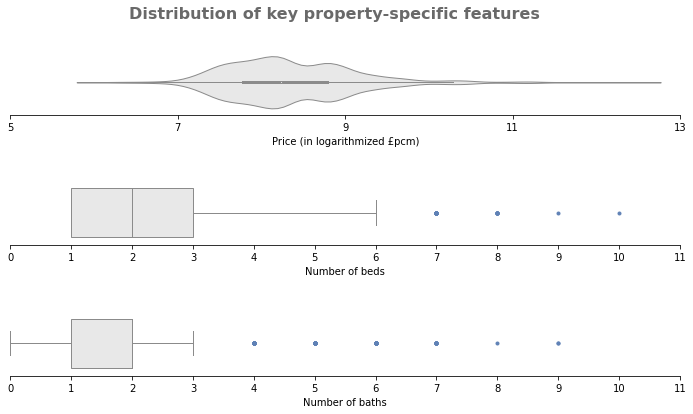

In [42]:
#Key numeric variables containing property-specific information
fig, ax = plt.subplots(figsize = (12, 6), ncols = 1, nrows = 3)
fig.subplots_adjust(hspace = 1)
sns.despine(top = True, left = True)
fig.suptitle("Distribution of key property-specific features",
                   color = "#696969",
                   weight = "bold",
                   size = 16)

#Log price
price = sns.violinplot(
    x = "log_price", 
    data = df, 
    ax = ax[0], 
    color = "#E8E8E8", 
    linewidth = 1, 
    width = 0.8
)
price.set_yticks([])
price.set_xlim([5,13])
price.set_xticks([5,7,9,11,13])
price.set_xlabel("Price (in logarithmized £pcm)")
price.spines["left"].set_visible(False)

#Beds
beds = sns.boxplot(
    x = "nr_beds", 
    data = df, 
    ax = ax[1], 
    color = "#E8E8E8", 
    linewidth = 1, 
    width = 0.75,
    flierprops = {"marker": "o", 
                  "markerfacecolor": "#6082B6", 
                  "markersize": 3, 
                  "markeredgecolor": "#6082B6"} 
)
beds.set_yticks([])
beds.set_xlim([0,11])
beds.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
beds.set_xlabel("Number of beds")

#Baths
baths = sns.boxplot(
    x = "nr_baths", 
    data = df, 
    ax = ax[2], 
    color = "#E8E8E8", 
    linewidth = 1, 
    width = 0.75,
    flierprops = {"marker": "o", 
                  "markerfacecolor": "#6082B6", 
                  "markersize": 3, 
                  "markeredgecolor": "#6082B6"} 
)
baths.set_yticks([])
baths.set_xlim([0,11])
baths.set_xticks([0,1,2,3,4,5,6,7,8,9,10,11])
baths.set_xlabel("Number of baths")

Text(0.5, 0, "Mean income in postcode area (in £1'000)")

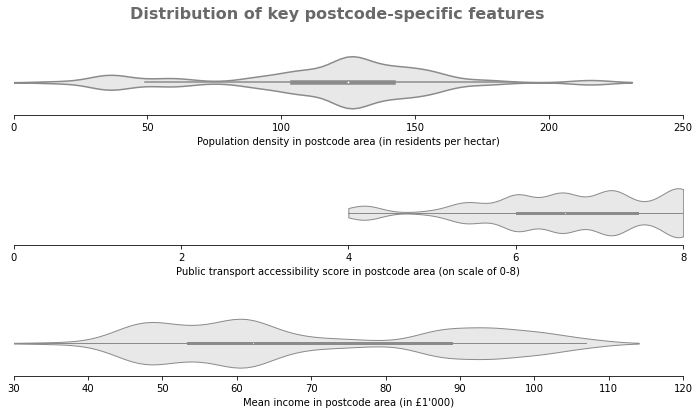

In [43]:
#Key numeric variables containing postcode-specific information
fig, ax = plt.subplots(figsize = (12, 6), ncols = 1, nrows = 3)
fig.subplots_adjust(hspace = 1)
sns.despine(top = True, left = True)
fig.suptitle("Distribution of key postcode-specific features",
                   color = "#696969",
                   weight = "bold",
                   size = 16)

#Population density in postcode area
pop_density = sns.violinplot(
    x = "pop_density", 
    data = df, 
    ax = ax[0], 
    color = "#E8E8E8"
)
pop_density.set_yticks([])
pop_density.set_xlim([0,250])
pop_density.set_xticks([0,50,100,150,200,250])
pop_density.set_xlabel("Population density in postcode area (in residents per hectar)")

#Public transport accessibility in postcode area
pt_accessibility = sns.violinplot(
    x = "public_transport_accessibility", 
    data = df, 
    ax = ax[1], 
    color = "#E8E8E8", 
    linewidth = 1, 
    width = 0.75,
    cut = 0
)
pt_accessibility.set_yticks([])
pt_accessibility.set_xlim([0,8])
pt_accessibility.set_xticks([0,2,4,6,8])
pt_accessibility.set_xlabel("Public transport accessibility score in postcode area (on scale of 0-8)")

#Mean income in postcode area
mean_income = sns.violinplot(
    x = "mean_income", 
    data = df, 
    ax = ax[2], 
    color = "#E8E8E8", 
    linewidth = 1, 
    width = 0.75
)
mean_income.set_yticks([])
mean_income.set_xlim([30,120])
mean_income.set_xticks([30,40,50,60,70,80,90,100,110,120])
mean_income.set_xlabel("Mean income in postcode area (in £1'000)")

Text(0.5, 1.0, 'Listings per bottom 10 nearest stations')

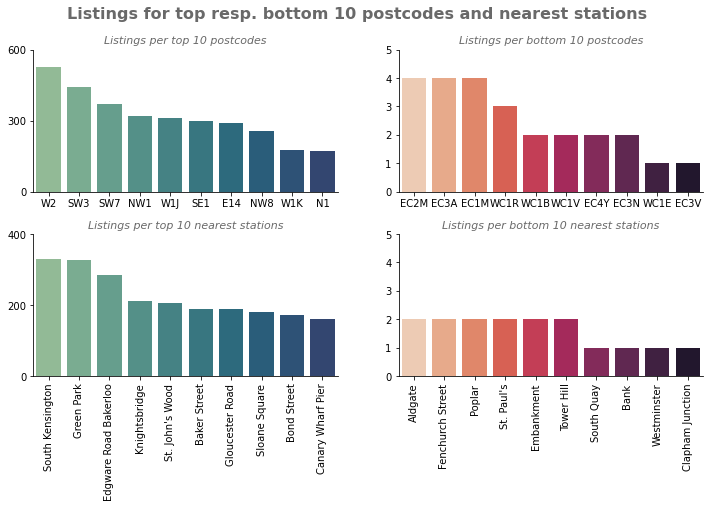

In [44]:
#Key categorical variables
frequentpcd = list(df["pcd"].value_counts().head(10).index)
leastfrequentpcd = list(df["pcd"].value_counts().tail(10).index)
selectionpcd = frequentpcd + leastfrequentpcd

fig, ax = plt.subplots(figsize = (12, 6), ncols = 2, nrows = 2)
sns.despine(top = True)
fig.subplots_adjust(hspace = 0.3)
fig.suptitle("Listings for top resp. bottom 10 postcodes and nearest stations",
                   color = "#696969",
                   weight = "bold",
                   size = 16)

#Top and least frequent postcodes
postcode = sns.countplot(
    x = df["pcd"], 
    data = df,
    ax = ax[0,0], 
    palette = "crest", 
    order = list(df["pcd"].value_counts().head(10).index))
postcode.set_ylim([0,600])
postcode.set_yticks([0,300,600])
postcode.set_xticklabels(postcode.get_xticklabels(), rotation = 0)
postcode.set_xlabel("")
postcode.set_ylabel("")
postcode.set_title("Listings per top 10 postcodes",
                   color = "#696969",
                   style = "italic",
                   size = 11)

#Least frequent postcodes
postcode = sns.countplot(
    x = df["pcd"], 
    data = df,
    ax = ax[0,1], 
    palette = "rocket_r", 
    order = df["pcd"].value_counts().tail(10).index)
postcode.set_ylim([0,5])
postcode.set_yticks([0,1,2,3,4,5])
postcode.set_xticklabels(postcode.get_xticklabels(), rotation = 0)
postcode.set_xlabel("")
postcode.set_ylabel("")
postcode.set_title("Listings per bottom 10 postcodes",
                   color = "#696969",
                   style = "italic",
                   size = 11)

#Top nearest stations
station_1 = sns.countplot(
    x = df["station_1"], 
    data = df,
    ax = ax[1,0], 
    palette = "crest", 
    order = df["station_1"].value_counts().head(10).index)
station_1.set_ylim([0,400])
station_1.set_yticks([0,200,400])
station_1.set_xticklabels(station_1.get_xticklabels(), rotation = 90)
station_1.set_xlabel("")
station_1.set_ylabel("")
station_1.set_title("Listings per top 10 nearest stations",
                   color = "#696969",
                   style = "italic",
                   size = 11)

#Least frequent nearest stations
station_1 = sns.countplot(
    x = df["station_1"], 
    data = df,
    ax = ax[1,1], 
    palette = "rocket_r", 
    order = df["station_1"].value_counts().tail(10).index)
station_1.set_ylim([0,5])
station_1.set_yticks([0,1,2,3,4,5])
station_1.set_xticklabels(station_1.get_xticklabels(), rotation = 90)
station_1.set_xlabel("")
station_1.set_ylabel("")
station_1.set_title("Listings per bottom 10 nearest stations",
                   color = "#696969",
                   style = "italic",
                   size = 11)

Text(0.5, 1.0, 'Health levels distribution per postcode')

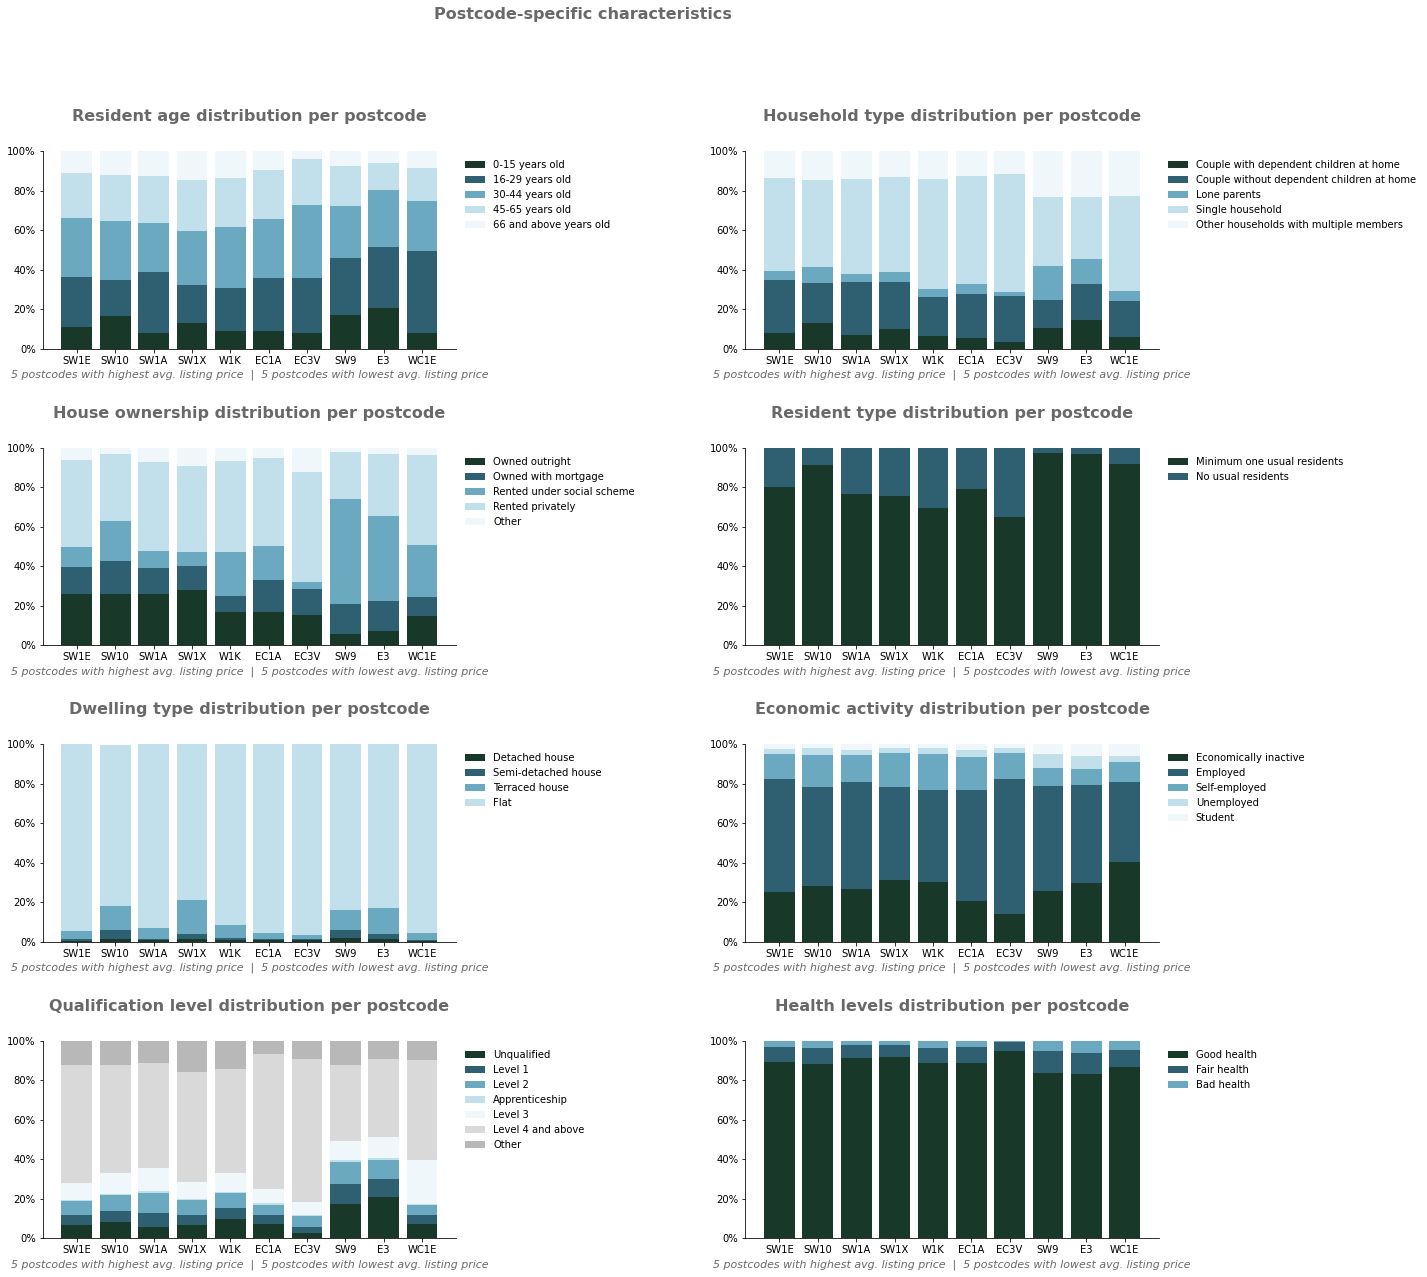

In [45]:
#Key features of most and least expensive postcodes
dfmostexpensivepcd = df.groupby("pcd").mean().sort_values("price", ascending = False).head(5)
dfcheapestpcd = df.groupby("pcd").mean().sort_values("price", ascending = False).tail(5)
dfselectionpcd = dfmostexpensivepcd.append(dfcheapestpcd)

fig, ax = plt.subplots(figsize = (20, 20), ncols = 2, nrows = 4)
fig.subplots_adjust(hspace = 0.5, wspace = 0.7)
sns.despine(top = True)
fig.suptitle("Postcode-specific characteristics",
             color = "#696969",
             weight = "bold",
             size = 16)

#Age distribution
axis = (0,0)
fields = ['ages_0_15','ages_16_29','ages_30_44','ages_45_65','ages_66_plus']
colors = ["#183929", "#2f6071", "#6aa9bf", "#c1e0eb", "#eff7fa"]
bottom = len(dfselectionpcd) * [0]
for index, name in enumerate(fields):
    ax[axis].bar(dfselectionpcd.index, 
              dfselectionpcd[name], 
              bottom = bottom, 
              color = colors[index])
    bottom = bottom + dfselectionpcd[name]

labels = ['0-15 years old', 
          '16-29 years old', 
          '30-44 years old', 
          '45-65 years old', 
          '66 and above years old']    
ax[axis].legend(labels, bbox_to_anchor = ([1, 1, 0, 0]), ncol = 1, frameon = False)
ax[axis].set_ylim([0,1])
ax[axis].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[axis].set_xlabel("5 postcodes with highest avg. listing price  |  5 postcodes with lowest avg. listing price",
                   color = "#696969",
                   style = "italic",
                   size = 11)
ax[axis].set_title("Resident age distribution per postcode",
                   color = "#696969",
                   weight = "bold",
                   size = 16, 
                   pad = 30)

#Household type distribution
axis = (0,1)
fields = ['couple_children_dependent','couple_children_nondependent', 'lone_parent', 'single', 'other_multi']
colors = ["#183929", "#2f6071", "#6aa9bf", "#c1e0eb", "#eff7fa"]
bottom = len(dfselectionpcd) * [0]
for index, name in enumerate(fields):
    ax[axis].bar(dfselectionpcd.index, 
              dfselectionpcd[name], 
              bottom = bottom, 
              color = colors[index])
    bottom = bottom + dfselectionpcd[name]

labels = ['Couple with dependent children at home', 
          'Couple without dependent children at home', 
          'Lone parents', 
          'Single household', 
          'Other households with multiple members']    
ax[axis].legend(labels, bbox_to_anchor = ([1, 1, 0, 0]), ncol = 1, frameon = False)
ax[axis].set_ylim([0,1])
ax[axis].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[axis].set_xlabel("5 postcodes with highest avg. listing price  |  5 postcodes with lowest avg. listing price",
                   color = "#696969",
                   style = "italic",
                   size = 11)
ax[axis].set_title("Household type distribution per postcode",
                   color = "#696969",
                   weight = "bold",
                   size = 16, 
                   pad = 30)

#House ownership distribution
axis = (1,0)
fields = ['owned_outright', 'owned_mortgage', 'rented_social', 'rented_private', 'other_ownership']
colors = ["#183929", "#2f6071", "#6aa9bf", "#c1e0eb", "#eff7fa"]
bottom = len(dfselectionpcd) * [0]
for index, name in enumerate(fields):
    ax[axis].bar(dfselectionpcd.index, 
              dfselectionpcd[name], 
              bottom = bottom, 
              color = colors[index])
    bottom = bottom + dfselectionpcd[name]

labels = ['Owned outright', 
          'Owned with mortgage', 
          'Rented under social scheme', 
          'Rented privately', 
          'Other']    
ax[axis].legend(labels, bbox_to_anchor = ([1, 1, 0, 0]), ncol = 1, frameon = False)
ax[axis].set_ylim([0,1])
ax[axis].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[axis].set_xlabel("5 postcodes with highest avg. listing price  |  5 postcodes with lowest avg. listing price",
                   color = "#696969",
                   style = "italic",
                   size = 11)
ax[axis].set_title("House ownership distribution per postcode",
                   color = "#696969",
                   weight = "bold",
                   size = 16, 
                   pad = 30)

#Resident type distribution
axis = (1,1)
fields = ['usual_residents', 'nonusual_residents']
colors = ["#183929", "#2f6071", "#6aa9bf", "#c1e0eb", "#eff7fa"]
bottom = len(dfselectionpcd) * [0]
for index, name in enumerate(fields):
    ax[axis].bar(dfselectionpcd.index, 
              dfselectionpcd[name], 
              bottom = bottom, 
              color = colors[index])
    bottom = bottom + dfselectionpcd[name]

labels = ['Minimum one usual residents', 
          'No usual residents']    
ax[axis].legend(labels, bbox_to_anchor = ([1, 1, 0, 0]), ncol = 1, frameon = False)
ax[axis].set_ylim([0,1])
ax[axis].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[axis].set_xlabel("5 postcodes with highest avg. listing price  |  5 postcodes with lowest avg. listing price",
                   color = "#696969",
                   style = "italic",
                   size = 11)
ax[axis].set_title("Resident type distribution per postcode",
                   color = "#696969",
                   weight = "bold",
                   size = 16, 
                   pad = 30)

#House type distribution
axis = (2,0)
fields = ['house_detached','house_semidetached', 'house_terraced', 'flat']
colors = ["#183929", "#2f6071", "#6aa9bf", "#c1e0eb", "#eff7fa"]
bottom = len(dfselectionpcd) * [0]
for index, name in enumerate(fields):
    ax[axis].bar(dfselectionpcd.index, 
              dfselectionpcd[name], 
              bottom = bottom, 
              color = colors[index])
    bottom = bottom + dfselectionpcd[name]

labels = ['Detached house', 
          'Semi-detached house', 
          'Terraced house',
          'Flat']    
ax[axis].legend(labels, bbox_to_anchor = ([1, 1, 0, 0]), ncol = 1, frameon = False)
ax[axis].set_ylim([0,1])
ax[axis].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[axis].set_xlabel("5 postcodes with highest avg. listing price  |  5 postcodes with lowest avg. listing price",
                   color = "#696969",
                   style = "italic",
                   size = 11)
ax[axis].set_title("Dwelling type distribution per postcode",
                   color = "#696969",
                   weight = "bold",
                   size = 16, 
                   pad = 30)

#Economic activity distribution
axis = (2,1)
fields = ['economic_inactive', 'employee', 'self-employed', 'unemployed','student']
colors = ["#183929", "#2f6071", "#6aa9bf", "#c1e0eb", "#eff7fa"]
bottom = len(dfselectionpcd) * [0]
for index, name in enumerate(fields):
    ax[axis].bar(dfselectionpcd.index, 
              dfselectionpcd[name], 
              bottom = bottom, 
              color = colors[index])
    bottom = bottom + dfselectionpcd[name]

labels = ['Economically inactive', 
          'Employed', 
          'Self-employed',
          'Unemployed', 
          'Student']    
ax[axis].legend(labels, bbox_to_anchor = ([1, 1, 0, 0]), ncol = 1, frameon = False)
ax[axis].set_ylim([0,1])
ax[axis].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[axis].set_xlabel("5 postcodes with highest avg. listing price  |  5 postcodes with lowest avg. listing price",
                   color = "#696969",
                   style = "italic",
                   size = 11)
ax[axis].set_title("Economic activity distribution per postcode",
                   color = "#696969",
                   weight = "bold",
                   size = 16, 
                   pad = 30)

#Qualitfication level distribution
axis = (3,0)
fields = ['unqualified', 'level_1', 'level_2', 'apprenticeship','level_3', 'level_4', 'other']
colors = ["#183929", "#2f6071", "#6aa9bf", "#c1e0eb", "#eff7fa", "#d9d9d9", "#b8b8b8"]
bottom = len(dfselectionpcd) * [0]
for index, name in enumerate(fields):
    ax[axis].bar(dfselectionpcd.index, 
              dfselectionpcd[name], 
              bottom = bottom, 
              color = colors[index])
    bottom = bottom + dfselectionpcd[name]

labels = ['Unqualified', 
          'Level 1', 
          'Level 2',
          'Apprenticeship', 
          'Level 3', 
          'Level 4 and above', 
          'Other']    
ax[axis].legend(labels, bbox_to_anchor = ([1, 1, 0, 0]), ncol = 1, frameon = False)
ax[axis].set_ylim([0,1])
ax[axis].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[axis].set_xlabel("5 postcodes with highest avg. listing price  |  5 postcodes with lowest avg. listing price",
                   color = "#696969",
                   style = "italic",
                   size = 11)
ax[axis].set_title("Qualification level distribution per postcode",
                   color = "#696969",
                   weight = "bold",
                   size = 16, 
                   pad = 30)

#Health distribution
axis = (3,1)
fields = ['good_health', 'fair_health','bad_health']
colors = ["#183929", "#2f6071", "#6aa9bf", "#c1e0eb", "#eff7fa"]
bottom = len(dfselectionpcd) * [0]
for index, name in enumerate(fields):
    ax[axis].bar(dfselectionpcd.index, 
              dfselectionpcd[name], 
              bottom = bottom, 
              color = colors[index])
    bottom = bottom + dfselectionpcd[name]

labels = ['Good health', 
          'Fair health', 
          'Bad health']    
ax[axis].legend(labels, bbox_to_anchor = ([1, 1, 0, 0]), ncol = 1, frameon = False)
ax[axis].set_ylim([0,1])
ax[axis].yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax[axis].set_xlabel("5 postcodes with highest avg. listing price  |  5 postcodes with lowest avg. listing price",
                   color = "#696969",
                   style = "italic",
                   size = 11)
ax[axis].set_title("Health levels distribution per postcode",
                   color = "#696969",
                   weight = "bold",
                   size = 16, 
                   pad = 30)

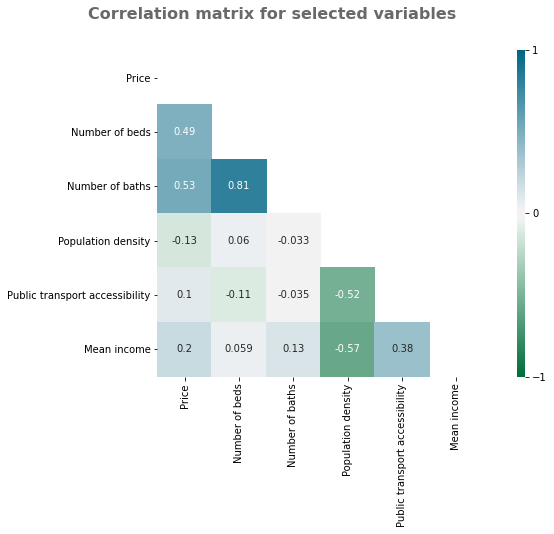

In [46]:
#Correlation matrix for selected variables
corr = df.loc[:,["price", "nr_beds", "nr_baths", "pop_density", "public_transport_accessibility", "mean_income"]].corr()

fig, ax = plt.subplots(figsize = (12, 6))
fig.suptitle("Correlation matrix for selected variables",
                   color = "#696969",
                   weight = "bold",
                   size = 16)
colors = sns.diverging_palette(37, 12.5, as_cmap = True)
mask = np.triu(np.ones_like(corr, dtype = bool))
labels = ["Price", "Number of beds", "Number of baths", "Population density", "Public transport accessibility", "Mean income"]

ax = sns.heatmap(data = corr, 
                 mask = mask,
                 vmin = -1,
                 vmax = 1,
                 square = True, 
                 annot = True,
                 xticklabels = labels,
                 yticklabels = labels,
                 cmap = sns.diverging_palette(140, 230, l = 40, s = 100, sep = 10, as_cmap = True),
                 cbar_kws = {
                     "orientation": "vertical", 
                     "shrink": 1,
                     "aspect": 40})

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-1.0, 0, 1.0])

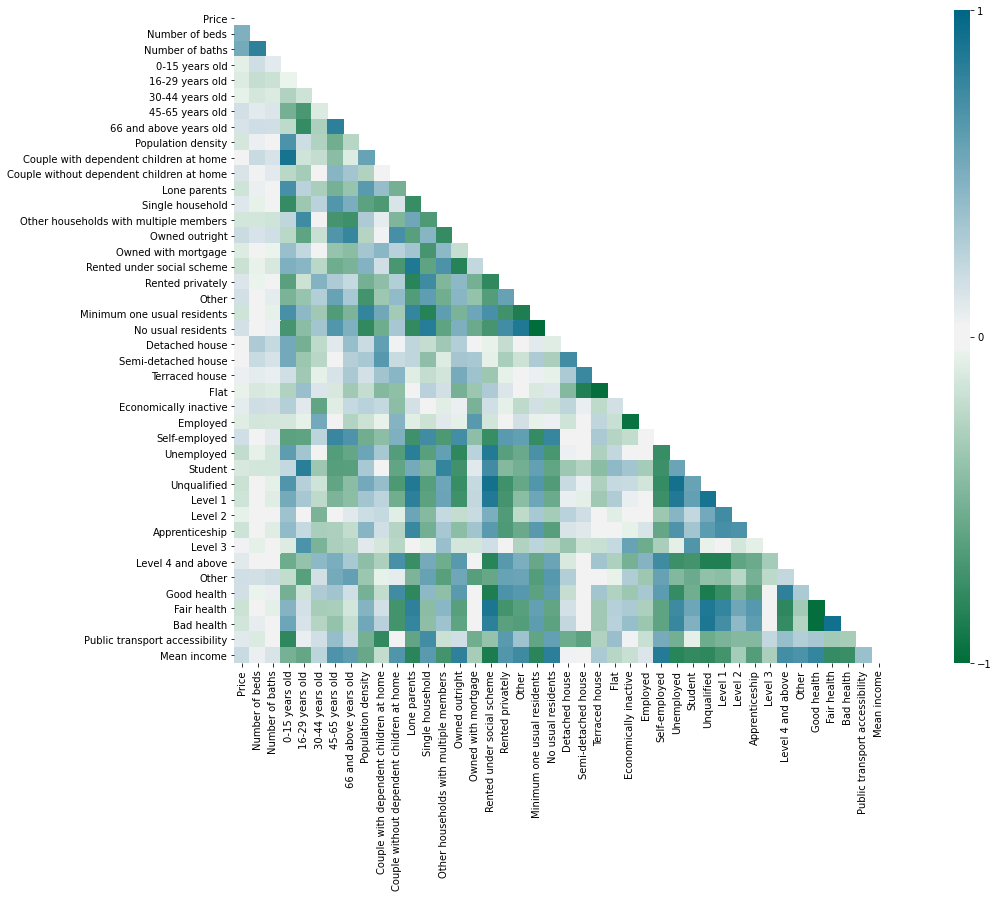

In [47]:
#Correlation matrix for all variables
corr = df.loc[:,["price", 
                 "nr_beds", 
                 "nr_baths", 
                 "pcd", 
                 "station_1",
                 "ages_0_15", 
                 "ages_16_29", 
                 "ages_30_44", 
                 "ages_45_65", 
                 "ages_66_plus",
                 "pop_density", 
                 "couple_children_dependent",
                 "couple_children_nondependent", 
                 "lone_parent", 
                 "single", 
                 "other_multi", 
                 "owned_outright", 
                 "owned_mortgage", 
                 "rented_social", 
                 "rented_private",
                 "other_ownership",
                 "usual_residents", 
                 "nonusual_residents", 
                 "house_detached",
                 "house_semidetached", 
                 "house_terraced", 
                 "flat", 
                 "economic_inactive", 
                 "employee", 
                 "self-employed", 
                 "unemployed",
                 "student", 
                 "unqualified", 
                 "level_1", 
                 "level_2", 
                 "apprenticeship", 
                 "level_3", 
                 "level_4", 
                 "other", 
                 "good_health", 
                 "fair_health", 
                 "bad_health", 
                 "public_transport_accessibility", 
                 "mean_income"]].corr()

fig, ax = plt.subplots(figsize = (24, 12))
colors = sns.diverging_palette(37, 12.5, as_cmap = True)
mask = np.triu(np.ones_like(corr, dtype = bool))
labels = ["Price", 
          "Number of beds", 
          "Number of baths", 
          "0-15 years old", 
          "16-29 years old", 
          "30-44 years old", 
          "45-65 years old", 
          "66 and above years old",
          "Population density",
          "Couple with dependent children at home", 
          "Couple without dependent children at home", 
          "Lone parents", 
          "Single household", 
          "Other households with multiple members",
          "Owned outright", 
          "Owned with mortgage", 
          "Rented under social scheme", 
          "Rented privately",
          "Other",
          "Minimum one usual residents", 
          "No usual residents",
          "Detached house", 
          "Semi-detached house", 
          "Terraced house",
          "Flat",
          "Economically inactive", 
          "Employed", 
          "Self-employed",
          "Unemployed", 
          "Student",
          "Unqualified", 
          "Level 1", 
          "Level 2",
          "Apprenticeship", 
          "Level 3", 
          "Level 4 and above", 
          "Other",
          "Good health", 
          "Fair health", 
          "Bad health",
          "Public transport accessibility", 
          "Mean income"]

ax = sns.heatmap(data = corr, 
                 mask = mask,
                 vmin = -1,
                 vmax = 1,
                 square = True, 
                 annot = False,
                 xticklabels = labels,
                 yticklabels = labels,
                 cmap = sns.diverging_palette(140, 230, l = 40, s = 100, sep = 10, as_cmap = True),
                 cbar_kws = {
                     "orientation": "vertical", 
                     "shrink": 1,
                     "aspect": 40})

colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-1.0, 0, 1.0])

## Chapter 5: <a class="anchor" id="chapter5"></a> Statistical Model

In [48]:
#Importing data
df = pd.read_csv("Data/Full_Dataset_VCleaned.csv", index_col = 0)

In [49]:
#Droping variables
dropped_var = ["price","lat","long","station_1"]
df = df.drop(dropped_var, axis = 1)
df.head()

,nr_beds,nr_baths,pcd,ages_0_15,ages_16_29,ages_30_44,ages_45_65,ages_66_plus,pop_density,couple_children_dependent,...,level_3,level_4,other,good_health,fair_health,bad_health,public_transport_accessibility,mean_income,log_price,other_ownership
0,2,2,SE1,0.128865,0.321420,0.283706,0.188647,0.077361,124.760208,0.083813,...,0.127582,0.483684,0.082278,0.853440,0.102529,0.044135,6.544094,47.944874,8.045588,0.036919
1,2,2,SE1,0.128865,0.321420,0.283706,0.188647,0.077361,124.760208,0.083813,...,0.127582,0.483684,0.082278,0.853440,0.102529,0.044135,6.544094,47.944874,7.901007,0.036919
2,3,2,SE1,0.128865,0.321420,0.283706,0.188647,0.077361,124.760208,0.083813,...,0.127582,0.483684,0.082278,0.853440,0.102529,0.044135,6.544094,47.944874,8.322880,0.036919
3,1,1,SE1,0.128865,0.321420,0.283706,0.188647,0.077361,124.760208,0.083813,...,0.127582,0.483684,0.082278,0.853440,0.102529,0.044135,6.544094,47.944874,8.017308,0.036919
4,1,1,NW1,0.156290,0.332249,0.244501,0.173026,0.093934,124.071408,0.101633,...,0.175979,0.427222,0.103377,0.844381,0.101470,0.054130,7.078981,47.298153,8.240649,0.030354


In [50]:
#Dummyfying postcode
vector_dummies = ["pcd"]
df_dummies = pd.get_dummies(df, columns = vector_dummies, drop_first = True)
df_dummies.head()

,nr_beds,nr_baths,ages_0_15,ages_16_29,ages_30_44,ages_45_65,ages_66_plus,pop_density,couple_children_dependent,couple_children_nondependent,...,pcd_WC1N,pcd_WC1R,pcd_WC1V,pcd_WC1X,pcd_WC2A,pcd_WC2B,pcd_WC2E,pcd_WC2H,pcd_WC2N,pcd_WC2R
0,2,2,0.128865,0.321420,0.283706,0.188647,0.077361,124.760208,0.083813,0.200702,...,0,0,0,0,0,0,0,0,0,0
1,2,2,0.128865,0.321420,0.283706,0.188647,0.077361,124.760208,0.083813,0.200702,...,0,0,0,0,0,0,0,0,0,0
2,3,2,0.128865,0.321420,0.283706,0.188647,0.077361,124.760208,0.083813,0.200702,...,0,0,0,0,0,0,0,0,0,0
3,1,1,0.128865,0.321420,0.283706,0.188647,0.077361,124.760208,0.083813,0.200702,...,0,0,0,0,0,0,0,0,0,0
4,1,1,0.156290,0.332249,0.244501,0.173026,0.093934,124.071408,0.101633,0.181760,...,0,0,0,0,0,0,0,0,0,0


In [51]:
#Lasso regression
X = df_dummies.drop(["log_price"], axis = 1)
Y = df_dummies["log_price"]

lasso = LassoCV()
lasso.fit(X, Y)
print("Best alpha using built-in LassoCV: %f" % lasso.alpha_)
print("Best score using built-in LassoCV: %f" %lasso.score(X,Y))

Best alpha using built-in LassoCV: 0.013520
Best score using built-in LassoCV: 0.662564


Text(0.5, 1.0, 'Feature importance under Lasso Regression')

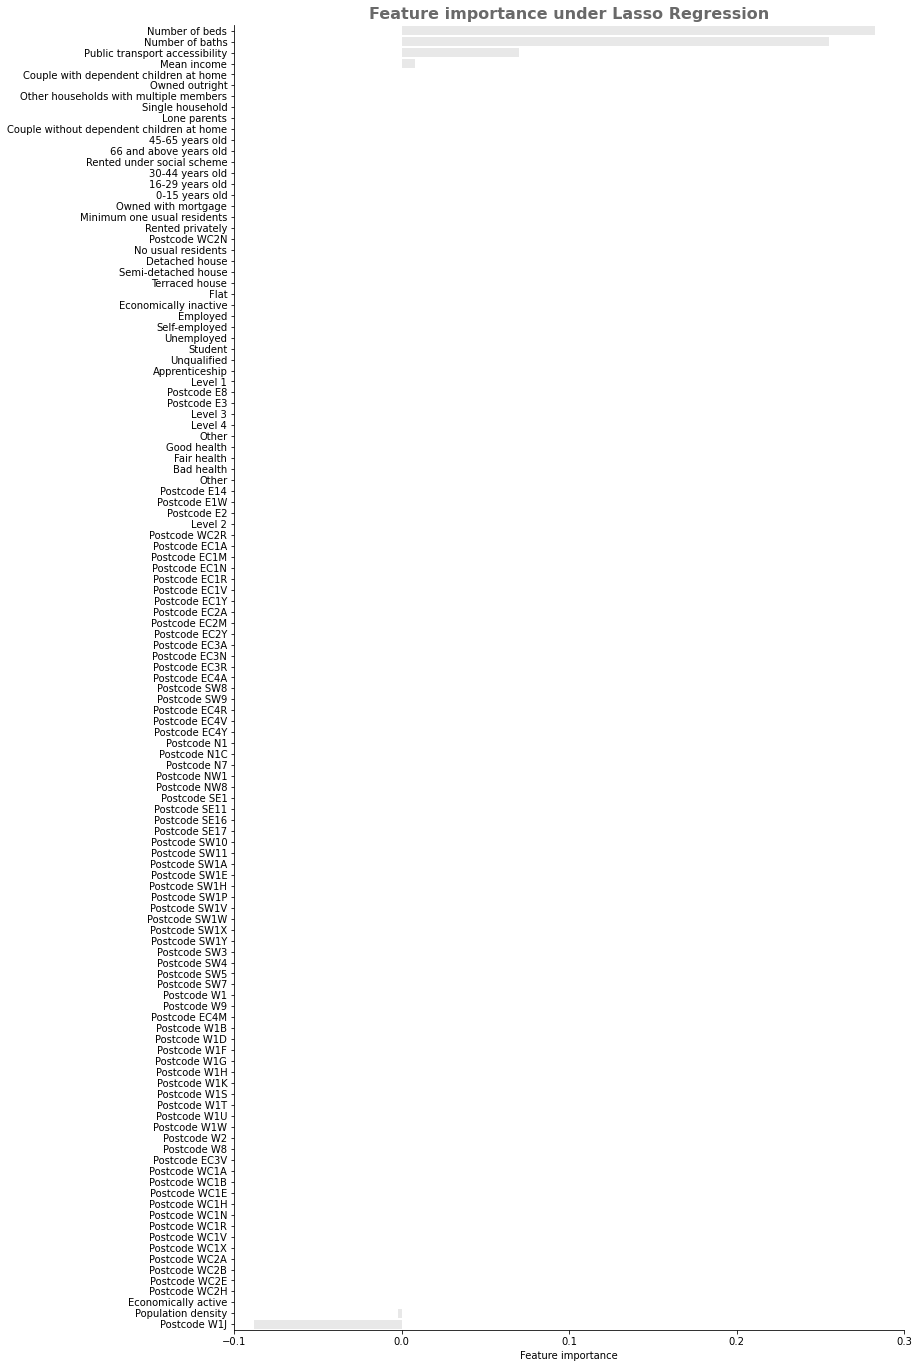

In [52]:
coef = pd.Series(lasso.coef_, index = X.columns)
imp_coef = coef.sort_values()

fig, ax = plt.subplots(figsize = (12, 24), ncols = 1, nrows = 1)
sns.despine(top = True)
labels = ["Number of beds", 
          "Number of baths",
          "Public transport accessibility",
          "Mean income",
          "Couple with dependent children at home",
          "Owned outright", 
          "Other households with multiple members",
          "Single household", 
          "Lone parents",
          "Couple without dependent children at home",
          "45-65 years old",
          "66 and above years old",
          "Rented under social scheme", 
          "30-44 years old",
          "16-29 years old",
          "0-15 years old", 
          "Owned with mortgage",
          "Minimum one usual residents",
          "Rented privately",
          "Postcode WC2N",
          "No usual residents",
          "Detached house", 
          "Semi-detached house", 
          "Terraced house",
          "Flat",
          "Economically inactive",
          "Employed", 
          "Self-employed",
          "Unemployed", 
          "Student",
          "Unqualified",
          "Apprenticeship",
          "Level 1",
          "Postcode E8",
          "Postcode E3",
          "Level 3",
          "Level 4",
          "Other",
          "Good health",
          "Fair health",
          "Bad health",
          "Other",
          "Postcode E14",
          "Postcode E1W",
          "Postcode E2",
          "Level 2",
          "Postcode WC2R",
          "Postcode EC1A",
          "Postcode EC1M",
          "Postcode EC1N",
          "Postcode EC1R",
          "Postcode EC1V",
          "Postcode EC1Y",
          "Postcode EC2A",
          "Postcode EC2M",
          "Postcode EC2Y",
          "Postcode EC3A",
          "Postcode EC3N",
          "Postcode EC3R",
          "Postcode EC4A",
          "Postcode SW8",
          "Postcode SW9",
          "Postcode EC4R",
          "Postcode EC4V",
          "Postcode EC4Y",
          "Postcode N1",
          "Postcode N1C",
          "Postcode N7",
          "Postcode NW1",
          "Postcode NW8",
          "Postcode SE1",
          "Postcode SE11",
          "Postcode SE16",
          "Postcode SE17",
          "Postcode SW10",
          "Postcode SW11",
          "Postcode SW1A",
          "Postcode SW1E",
          "Postcode SW1H",
          "Postcode SW1P",
          "Postcode SW1V",
          "Postcode SW1W",
          "Postcode SW1X",
          "Postcode SW1Y",
          "Postcode SW3",
          "Postcode SW4",
          "Postcode SW5",
          "Postcode SW7",
          "Postcode W1",
          "Postcode W9",
          "Postcode EC4M",
          "Postcode W1B",
          "Postcode W1D",
          "Postcode W1F",
          "Postcode W1G",
          "Postcode W1H",
          "Postcode W1K",
          "Postcode W1S",
          "Postcode W1T",
          "Postcode W1U",
          "Postcode W1W",
          "Postcode W2",
          "Postcode W8",
          "Postcode EC3V",
          "Postcode WC1A",
          "Postcode WC1B",
          "Postcode WC1E",
          "Postcode WC1H",
          "Postcode WC1N",
          "Postcode WC1R",
          "Postcode WC1V",
          "Postcode WC1X",
          "Postcode WC2A",
          "Postcode WC2B",
          "Postcode WC2E",
          "Postcode WC2H",
          "Economically active",
          "Population density",
          "Postcode W1J"]

imp_coef_plt = sns.barplot(
    y = imp_coef.to_frame().index,
    x = imp_coef.to_frame()[0],
    ax = ax,
    order = imp_coef.to_frame()[0].sort_values(ascending = False).index,
    color = "#E8E8E8")
imp_coef_plt.set_xlim([-0.1,0.3])
imp_coef_plt.set_xticks([-0.1,0.0,0.1,0.2,0.3])
imp_coef_plt.set_yticklabels(labels, rotation = 0)
imp_coef_plt.set_xlabel("Feature importance")
imp_coef_plt.set_title("Feature importance under Lasso Regression",
                   color = "#696969",
                   weight = "bold",
                   size = 16)

In [53]:
significant_vars = pd.DataFrame(coef[coef != 0])
significant_vars

,0
nr_beds,0.255451
nr_baths,0.282432
pop_density,-0.002233
economic_active,-0.000047
public_transport_accessibility,0.069764
mean_income,0.008047
pcd_W1J,-0.088195


In [54]:
var_lasso = significant_vars.index.to_list()
var_lasso.append("log_price")
df_dummies_imp = df_dummies[var_lasso]
df_dummies_imp.head()

,nr_beds,nr_baths,pop_density,economic_active,public_transport_accessibility,mean_income,pcd_W1J,log_price
0,2,2,124.760208,1078.37983,6.544094,47.944874,0,8.045588
1,2,2,124.760208,1078.37983,6.544094,47.944874,0,7.901007
2,3,2,124.760208,1078.37983,6.544094,47.944874,0,8.322880
3,1,1,124.760208,1078.37983,6.544094,47.944874,0,8.017308
4,1,1,124.071408,868.50072,7.078981,47.298153,0,8.240649


In [55]:
#Linear regression
X = df_dummies_imp.drop(["log_price"], axis = 1)
y = df_dummies_imp[["log_price"]].values.ravel()

X_rest, X_test, y_rest, y_test = train_test_split(X, y, test_size = 0.30, random_state = 0)
X_train, X_vali, y_train, y_vali = train_test_split(X_rest, y_rest, test_size = 0.30, random_state = 0)

training_mean = X_train.mean()
training_std =  X_train.std()

X_train = (X_train - training_mean) / training_std  
X_vali = (X_vali- training_mean) / training_std  
X_test = (X_test - training_mean) / training_std 

model_linear = sm.OLS(y_train, sm.add_constant(X_train), missing = "drop")
original_linear = model_linear.fit()
print(original_linear.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.670
Model:                            OLS   Adj. R-squared:                  0.670
Method:                 Least Squares   F-statistic:                     763.6
Date:                Wed, 05 Jan 2022   Prob (F-statistic):               0.00
Time:                        12:54:38   Log-Likelihood:                -1660.5
No. Observations:                2636   AIC:                             3337.
Df Residuals:                    2628   BIC:                             3384.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
const       

/Users/claragoebel/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:title={'center':'Residuals scatterplot'}, xlabel='Prediction', ylabel='Residuals'>

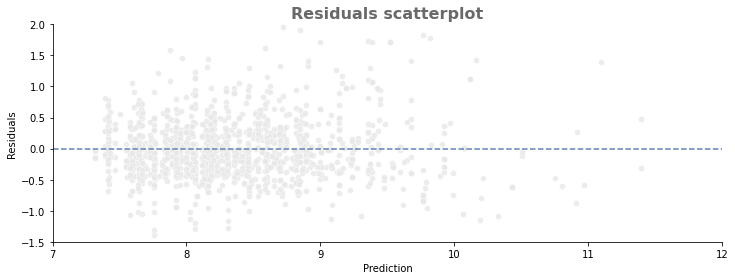

In [56]:
y_pred = model_linear.predict(original_linear.params, sm.add_constant(X_test))
residuals = y_test - y_pred

fig, ax = plt.subplots(figsize = (12, 4), ncols = 1, nrows = 1)
sns.despine(top = True)

residuals_plt = sns.scatterplot(
    x = y_pred,
    y = residuals,
    ax = ax, 
    color = "#E8E8E8",
    alpha = 0.8
)
residuals_plt.set_ylim([-1.5,2.0])
residuals_plt.set_xlim([7,12])
residuals_plt.set_xlabel("Prediction")
residuals_plt.set_ylabel("Residuals")
residuals_plt.set_title("Residuals scatterplot",
                   color = "#696969",
                   weight = "bold",
                   size = 16)

sns.lineplot([7,12],[0,0], color = "#6082B6", linestyle = "--", ax = ax)

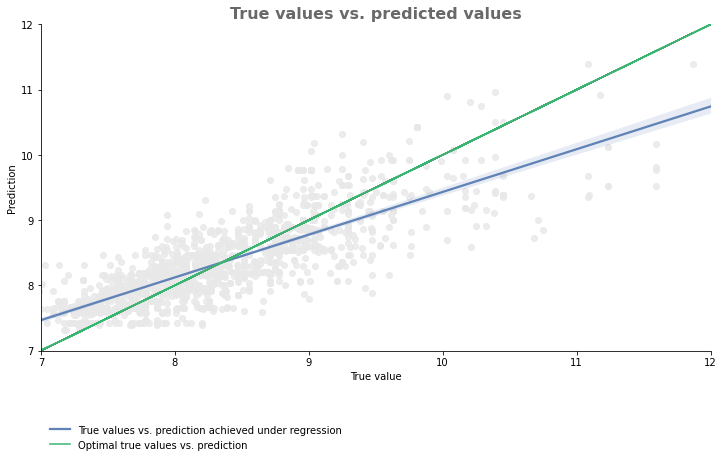

In [57]:
fig, ax = plt.subplots(figsize = (12, 6), ncols = 1, nrows = 1)
sns.despine(top = True)

error_plt = sns.regplot(
    x = y_test,
    y = y_pred,
    ax = ax, 
    color = "#E8E8E8",
    line_kws = {"color": "#6082B6"}
)
error_plt.set_ylim([7,12])
error_plt.set_xlim([7,12])
error_plt.set_xlabel("True value")
error_plt.set_ylabel("Prediction")
error_plt.set_title("True values vs. predicted values",
                   color = "#696969",
                   weight = "bold",
                   size = 16)

error_plt.plot(y_test, y_test, color = "#3CB371", linewidth = 1.5)

error_plt.legend(["True values vs. prediction achieved under regression", "Optimal true values vs. prediction"],
                 loc = "upper left", bbox_to_anchor = (0,-0.2,0,0), 
                 frameon = False)

## Chapter 6: <a class="anchor" id="chapter6"></a> References

London Statistics Office, 30 June 2014. London Residential Property Rental Market Trends. Available at https://data.london.gov.uk/dataset/super-output-area-population-lsoa-msoa-london. Accessed November 2021.

Zoopla, 2021. Zoopla > Search Property to Buy and Rent. Available at: https://www.zoopla.co.uk/. Accessed November 2021.